# Dataset
We use the [CiFake](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images) dataset, 
containing 60,0000 synthetically-generated images and 60,000 real images.

# Approach
The main idea is to divide each image into 4x4 tiles. We then calculate the mean and variation for each tile. Each 
image is represented as a vector consisting of the means and variations of each of its tiles. We then use the KNN 
algorithm.

# Overview Of Steps
## 1. Image Processing and Feature Extraction

1. **Convert Images to Grayscale**:
   1.1 **Function**: `to_gray(image)`
   1.2 Converts a color image to grayscale using OpenCV.

2. **Extract 4x4 Blocks from the Image**:
   2.1 **Function**: `get_n_blocks(arr, tile_size=4)`
   2.2 Divides the grayscale image into non-overlapping 4x4 blocks.

3. **Calculate Mean and Variance for Each Block**:
   3.1 **Function**: `get_block_means_vars(arr)`
   3.2 Computes the mean and variance for each 4x4 block and combines them.

4. **Compute Features for Each Image**:
   4.1 **Function**: `get_img_features(img)`
   4.2 Uses the above functions to get feature vectors for each image.

## 2. Load and Process Images

1. **Load Images from a Directory and Extract Features**:
   1.1 **Function**: `load_img_and_extract_features(filepath, label)`
   1.2 Reads an image file, converts it to grayscale, extracts features, and assigns a label.

2. **Load Multiple Images from a Directory**:
   2.1 **Function**: `load_imgs_from_directory(directory, label, num_images=None)`
   2.2 Loads a specified number of images from a directory, extracts features, and assigns labels.

## 3. Prepare the Dataset

1. **Specify Directories and Parameters**:
   1.1 Set paths to the directories containing fake and real images.
   1.2 Define the number of images to load from each directory.

2. **Load Images from Both Directories**:
   2.1 Load images from both the `FAKE` and `REAL` directories using the `load_imgs_from_directory` function.

3. **Combine Features and Labels**:
   3.1 Stack the feature arrays for both classes.
   3.2 Create a combined label array.

4. **Shuffle the Dataset**:
   4.1 Shuffle the features and labels to ensure random distribution.

5. **Split Dataset into Training and Testing Sets**:
   5.1 Use `train_test_split` from `sklearn` to split the dataset into training and testing sets.

## 4. Train and Evaluate k-NN Classifiers

1. **Initialize and Train k-NN Classifiers**:
   1.1 Loop over values of \( k \) from 1 to 11.
   1.2 Initialize a `KNeighborsClassifier` with the current \( k \).
   1.3 Train the classifier using the training data.

2. **Make Predictions and Compute Accuracy**:
   2.1 Predict labels for the test set using the trained model.
   2.2 Compute the accuracy of the model using `accuracy_score` from `sklearn`.

## 5. Plot Results

1. **Plot Accuracy vs. Number of Neighbors**

# TODO
Increase the resolution of images and see what happens.

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd

def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def get_n_blocks(arr, tile_size=4):
    rows, cols = arr.shape
    tilings = []

    for i in range(0, rows, tile_size):
        for j in range(0, cols, tile_size):
            tiling = arr[i:i + tile_size, j:j + tile_size]
            tilings.append(tiling)

    return np.array(tilings)


def get_block_means_vars(arr):
    means_vars = []
    for block in arr:
        means_vars.append(np.mean(block) + np.var(block))
    return np.array(means_vars)


def get_img_features(img):
    blocks = get_n_blocks(img)
    return get_block_means_vars(blocks)


def load_img_and_extract_features(filepath, label):
    img = cv2.imread(filepath)
    gray_img = to_gray(img)
    features = get_img_features(gray_img)
    return features, label


def load_imgs_from_directory(directory, label, num_images=None):
    images = []
    labels = []
    files = os.listdir(directory)
    if num_images is not None:
        files = files[:num_images]
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(load_img_and_extract_features, os.path.join(directory, filename), label) for filename
                   in files]
        for future in as_completed(futures):
            features, lbl = future.result()
            images.append(features)
            labels.append(lbl)
    return images, labels


base_dir = "train"
fake_dir = os.path.join(base_dir, 'FAKE')
real_dir = os.path.join(base_dir, 'REAL')
    
num_images_to_load = 10000

fake_images, fake_labels = load_imgs_from_directory(fake_dir, 0, num_images=num_images_to_load)
real_images, real_labels = load_imgs_from_directory(real_dir, 1, num_images=num_images_to_load)

features = np.vstack((fake_images, real_images))
labels = np.concatenate((fake_labels, real_labels))
                    
       



X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

accuracy = knn.score(X_test, y_test)
print("Accuracy:", accuracy)

training_accuracy = knn.score(X_train, y_train)
print(f"Training Accuracy: {training_accuracy}")
predictions = knn.predict(X_test[:20])
actual_labels = y_test[:20]

# for i in range(len(predictions)):
#     print(f"Predicted: {predictions[i]}\tActual: {actual_labels[i]}")   

predicted_vs_actual = pd.DataFrame({"Actual": actual_labels, "Predicted": predictions})
predicted_vs_actual


Accuracy: 0.671
Training Accuracy: 0.8314375


,Actual,Predicted
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
5,1,1
6,1,1
7,0,1
8,1,1
9,0,0


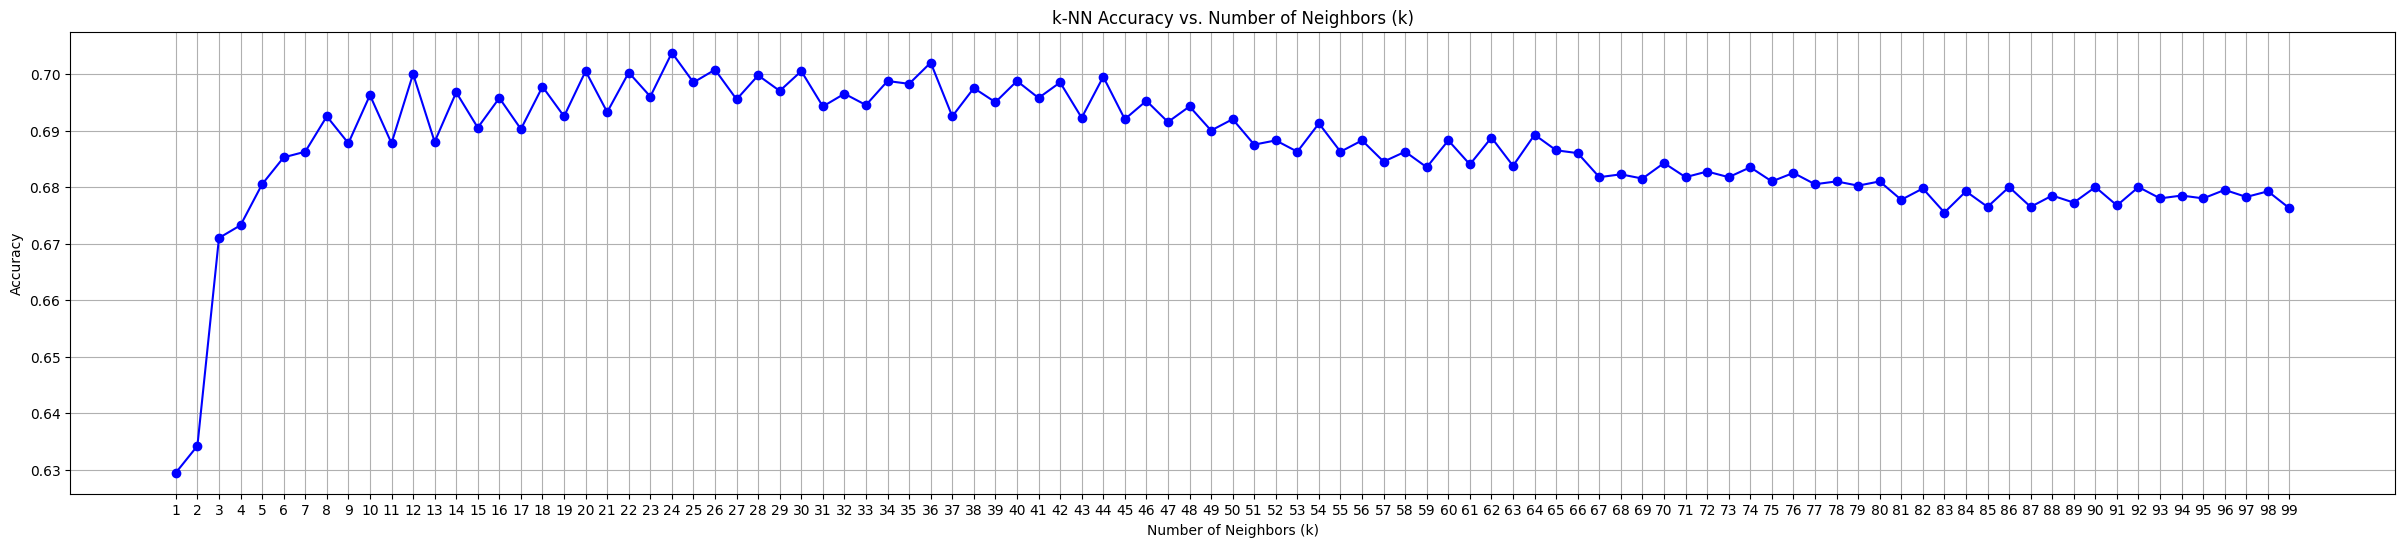

,K-Value,Accuracy
1,1,0.62950
2,2,0.63425
3,3,0.67100
4,4,0.67325
5,5,0.68050
...,...,...
95,95,0.67800
96,96,0.67950
97,97,0.67825
98,98,0.67925


In [4]:
k_values = range(1, 100)
accuracies = []


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    # print(f"Accuracy for k={k}: {accuracy}")
    
accuracies_df = pd.DataFrame({"K-Value":k_values,"Accuracy": accuracies},index=k_values)

plt.figure(figsize=(30, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('k-NN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

accuracies_df

# Approach 2
Here, the features are 